## Semantic similarity stuff needs spaCy and BERT. Pulling from one CSV file with mulitple rows
to do:
I need to figure out the preprocessing (I need sentences, leave stop words for now, but maybe get rid of non-alphanumeric)

# Step 1: Set Up the Environment

Install in virtual environment
1. conda create -n bertopic-env python=3.10
2. conda activate bertopic-env
3. conda install -c conda-forge spacy
4. conda install -c conda-forge cupy
5. conda install -c conda-forge bertopic
6. conda install -c conda-forge openpyxl
7. conda install -c conda-forge ipywidgets
8. conda install -c conda-forge jupyter_core
9. python -m spacy download en_core_web_trf


In [ ]:
%pip install spacy
%pip install cupy
%pip install bertopic
%pip install openpyxl
%pip install nltk
%pip install llama_index
%pip install sentence_transformers

In [8]:
%pip install bertopic

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 49.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 59.3 MB/s eta 0:00:0000:0100:01
  Created wheel for hdbscan: filename=hdbscan-0.8.38.post1-cp311-cp311-macosx_11_0_arm64.whl size=705142 sha256=712c63c0f55d25007e0846d0bbafac1787ee7b360e651f445e0c4bc86b100d21
  Stored in directory: /Users/kevinhall/Library/Caches/pip/wheels/cb/5e/46/545115df7b61e96c70d9d63dc207bd6939658350e7c1ed208a
Successfully built hdbscan
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!python -m spacy download en_core_web_trf

In [1]:
import torch

print("CUDA Available: ", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Device Name: ", torch.cuda.get_device_name(0))



CUDA Available:  False


# Check for GPU with CUDA core

# Step 1 Load and Preprocess the data with spaCy

In [18]:
# Define the path to your directory containing CSV files
path_to_files = "data/Interviews" 

## New code starts from here

In [19]:
import pandas as pd
import os
import nltk
from nltk.tokenize import sent_tokenize
from tqdm import tqdm

# Ensure necessary nltk resources are downloaded
nltk.download('punkt_tab')

def load_texts_from_csv_directory(directory_path):
    texts = []
    files_processed = 0
    file_names = []
    for filename in tqdm(os.listdir(directory_path)):
        if filename.endswith(".csv"):
            files_processed += 1
            file_names.append(filename)
            file_path = os.path.join(directory_path, filename)
            df = pd.read_csv(file_path)
            if 'text' in df.columns:
                texts.extend(df['text'].apply(lambda text: text.replace('\n', ' ').replace('yeah', '').replace('Yeah', '')).tolist())
            else:
                print(f"Column 'text' not found in {filename}")
    print(f"Total files processed: {files_processed}")
    print("Files processed:", file_names)
    return texts


# Load texts
documents = load_texts_from_csv_directory(path_to_files)

# Assuming each document is already a string
# Split each document into sentences
sentences = [sent_tokenize(doc) for doc in documents]
sentences = [sentence for doc in sentences for sentence in doc]

print("Processed Sentences:", sentences)


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/kevinhall/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
100%|██████████| 11/11 [00:00<00:00, 190.94it/s]


Total files processed: 1
Files processed: ['highlighted_sentences.csv']
Processed Sentences: ['So what are you teaching?', "I think that's my only role outside of the classroom at the moment.", 'Love teaching.', ' the needs of a few students who definitely need a lot of one-on-one attention with the needs of the rest of the classroom.', 'And then gradually figure out how to take those away for some students and figure out where I need to push more with other students, like sort of add more supports for some students.', 'There are students who are going to sit in my class every day, right?', 'Like, to the individual students.', ', to the individual students.', ' at the expense of teaching important content and giving important examples and anecdotes.', ' have really lofty discussions that end up having no real bearing on what happens in the classroom.', 'Teach a group of students.', 'I can think about those ideas later, but right now I need to teach this group of students.', 'Like, beca

In [20]:
print(documents[0:5])

['So what are you teaching?', "I think that's my only role outside of the classroom at the moment.", 'Love teaching.', ' the needs of a few students who definitely need a lot of one-on-one attention with the needs of the rest of the classroom.', 'And then gradually figure out how to take those away for some students and figure out where I need to push more with other students, like sort of add more supports for some students.']


In [21]:
print(f"Number of sentences: {len(sentences)}")
print(sentences[0:20])

Number of sentences: 68
['So what are you teaching?', "I think that's my only role outside of the classroom at the moment.", 'Love teaching.', ' the needs of a few students who definitely need a lot of one-on-one attention with the needs of the rest of the classroom.', 'And then gradually figure out how to take those away for some students and figure out where I need to push more with other students, like sort of add more supports for some students.', 'There are students who are going to sit in my class every day, right?', 'Like, to the individual students.', ', to the individual students.', ' at the expense of teaching important content and giving important examples and anecdotes.', ' have really lofty discussions that end up having no real bearing on what happens in the classroom.', 'Teach a group of students.', 'I can think about those ideas later, but right now I need to teach this group of students.', 'Like, because you, have you taught in a classroom?', "Here's the thing that you

In [22]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embedding_model.encode(sentences, show_progress_bar=True)

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired

topic_model = BERTopic(
  embedding_model=embedding_model,
  representation_model=KeyBERTInspired(),
  ctfidf_model=ClassTfidfTransformer(reduce_frequent_words=True),
  top_n_words=25
)
topics, probs = topic_model.fit_transform(sentences, embeddings)

## Topic Reduction

In [10]:
model = BERTopic(nr_topics=20)

## Merge Selected Topics

In [ ]:
topics_to_merge = [1, 2]
topic_model.merge_topics(sentences, topics, topics_to_merge)

## Make Predictions?

In [ ]:
topics, probs = topic_model.transform(sentences)

## List Top Topics

In [24]:
topic_model.get_topic_freq().head(11)

,Topic,Count
2,0,23
3,1,21
0,2,13
1,-1,11


## Get Topic info

In [25]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,11,-1_students_classroom_teaching_teach,"[students, classroom, teaching, teach, teacher...",[And you have to be a good enough teacher to c...
1,0,23,0_students_student_school_learn,"[students, student, school, learn, grade, clas...",[And like being able to know your students wel...
2,1,21,1_students_student_learning_curriculum,"[students, student, learning, curriculum, assi...","[So in this project, one goal we have is for s..."
3,2,13,2_classroom_teaching_teachers_students,"[classroom, teaching, teachers, students, teac...",[ have really lofty discussions that end up ha...


## Most frequent words for a specific topic

In [26]:
topic_model.get_topic(2)

[('classroom', 0.6053837),
 ('teaching', 0.6051439),
 ('teachers', 0.555038),
 ('students', 0.5355807),
 ('teacher', 0.53408504),
 ('teach', 0.53329265),
 ('taught', 0.47712842),
 ('lessons', 0.46241057),
 ('student', 0.41882467),
 ('lesson', 0.40514258)]

## Get Document Info

In [28]:
topic_model.get_document_info(sentences)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,So what are you teaching?,2,2_classroom_teaching_teachers_students,"[classroom, teaching, teachers, students, teac...",[ have really lofty discussions that end up ha...,classroom - teaching - teachers - students - t...,0.985245,False
1,I think that's my only role outside of the cla...,2,2_classroom_teaching_teachers_students,"[classroom, teaching, teachers, students, teac...",[ have really lofty discussions that end up ha...,classroom - teaching - teachers - students - t...,1.000000,False
2,Love teaching.,-1,-1_students_classroom_teaching_teach,"[students, classroom, teaching, teach, teacher...",[And you have to be a good enough teacher to c...,students - classroom - teaching - teach - teac...,0.000000,False
3,the needs of a few students who definitely ne...,-1,-1_students_classroom_teaching_teach,"[students, classroom, teaching, teach, teacher...",[And you have to be a good enough teacher to c...,students - classroom - teaching - teach - teac...,0.000000,False
4,And then gradually figure out how to take thos...,-1,-1_students_classroom_teaching_teach,"[students, classroom, teaching, teach, teacher...",[And you have to be a good enough teacher to c...,students - classroom - teaching - teach - teac...,0.000000,True
...,...,...,...,...,...,...,...,...
63,you've seen students taking ownership of thei...,1,1_students_student_learning_curriculum,"[students, student, learning, curriculum, assi...","[So in this project, one goal we have is for s...",students - student - learning - curriculum - a...,0.896470,False
64,What do students need?,0,0_students_student_school_learn,"[students, student, school, learn, grade, clas...",[And like being able to know your students wel...,students - student - school - learn - grade - ...,1.000000,False
65,"The student themselves is the big part of it,...",0,0_students_student_school_learn,"[students, student, school, learn, grade, clas...",[And like being able to know your students wel...,students - student - school - learn - grade - ...,1.000000,False
66,"In general, I'm not saying, you know, I'm not ...",0,0_students_student_school_learn,"[students, student, school, learn, grade, clas...",[And like being able to know your students wel...,students - student - school - learn - grade - ...,0.935457,False


## Word cloud of specific topic

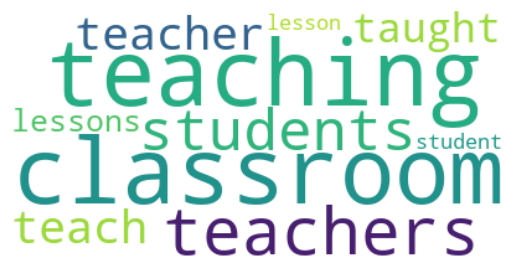

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
create_wordcloud(topic_model, topic=2)

## Visualize documents

In [30]:
topic_model.visualize_documents(sentences)

## New Setup with debugging

In [11]:
import os
import glob
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from umap import UMAP
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 1. Define key sentences
key_sentences = [
    "How do you support student learning in your classroom?",
    # Add more key sentences as needed
]

# 2. Generate embeddings for key sentences
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')  # Ensure this is defined
key_embeddings = embedding_model.encode(key_sentences)

# 3. Read and process transcripts
def read_transcript_csvs(directory):
    # Use '**/*.csv' to match CSV files in all subdirectories
    csv_files = glob.glob(os.path.join(directory, '**', '*.csv'), recursive=True)
    print(f"Found {len(csv_files)} CSV files in '{directory}' and its subdirectories.")
    
    transcript_data = []
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            # Verify necessary columns
            required_columns = ['text', 'sentence_number']
            for col in required_columns:
                if col not in df.columns:
                    print(f"Warning: '{col}' column missing in {file}. Skipping this file.")
                    raise ValueError(f"Missing '{col}' column.")
            # Add 'speaker' column if missing
            if 'speaker' not in df.columns:
                df['speaker'] = 'Unknown'
            # Capture relative path for 'source_file' to ensure uniqueness
            relative_path = os.path.relpath(file, directory)
            df['source_file'] = relative_path  # Use relative path instead of basename
            transcript_data.append(df)
            print(f"Successfully processed {relative_path}.")
        except Exception as e:
            print(f"Error reading {file}: {e}")
    return transcript_data

transcript_data = read_transcript_csvs('data/interviews')

# Debugging: Check 'source_file' in each DataFrame
for idx, df in enumerate(transcript_data):
    print(f"Transcript {idx + 1}: {df['source_file'].iloc[0]}")
    print(f"Columns: {df.columns.tolist()}\n")

# Preprocess function for text
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    else:
        return ''

# Compute embeddings in batches
def compute_embeddings_in_batches(texts, model, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch_embeddings = model.encode(batch)
        embeddings.extend(batch_embeddings)
    return embeddings

# Use the function for processing embeddings
for idx, df in enumerate(transcript_data):
    print(f"Processing embeddings for Transcript {idx + 1}: {df['source_file'].iloc[0]}")
    df['cleaned_text'] = df['text'].apply(preprocess_text)
    df['embedding'] = compute_embeddings_in_batches(df['cleaned_text'].tolist(), embedding_model)

# 4. Check for duplicate embeddings and remove them
embeddings = []
sentences_cleaned = []
for df in transcript_data:
    embeddings.extend(df['embedding'].tolist())
    sentences_cleaned.extend(df['cleaned_text'].tolist())

# Convert to NumPy array for easier manipulation
embeddings = np.array(embeddings)
sentences_cleaned = np.array(sentences_cleaned)

# Remove duplicate embeddings
unique_embeddings, unique_indices = np.unique(embeddings, axis=0, return_index=True)
if len(unique_embeddings) < len(embeddings):
    print(f"Removing {len(embeddings) - len(unique_embeddings)} duplicate embeddings.")
    embeddings = unique_embeddings
    sentences_cleaned = sentences_cleaned[unique_indices]

# 5. Initialize custom UMAP
num_sentences = len(sentences_cleaned)
custom_n_neighbors = min(15, max(5, num_sentences // 10)) if num_sentences >= 10 else num_sentences - 1
print(f"Using n_neighbors={custom_n_neighbors} for UMAP based on {num_sentences} samples.")

umap_model = UMAP(
    n_neighbors=custom_n_neighbors,
    n_components=2,
    metric='cosine',
    random_state=42
)

# 6. Initialize BERTopic with custom UMAP
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    representation_model=KeyBERTInspired(),
    ctfidf_model=ClassTfidfTransformer(reduce_frequent_words=True),
    top_n_words=25
)

# 7. Fit BERTopic model
topics, probs = topic_model.fit_transform(sentences_cleaned, embeddings)

# 8. Visualize topics
try:
    topic_model.visualize_topics(custom_labels=True)
except TypeError as e:
    print(f"Error during visualization: {e}")
    print("Attempting to adjust UMAP parameters and retry visualization.")

    # Adjust UMAP parameters (e.g., reduce n_neighbors further)
    adjusted_n_neighbors = max(5, custom_n_neighbors - 5)
    print(f"Reducing n_neighbors to {adjusted_n_neighbors} and retrying.")
    
    umap_model_adjusted = UMAP(
        n_neighbors=adjusted_n_neighbors,
        n_components=2,
        metric='cosine',
        random_state=42
    )
    
    # Reinitialize BERTopic with adjusted UMAP
    topic_model_adjusted = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model_adjusted,
        representation_model=KeyBERTInspired(),
        ctfidf_model=ClassTfidfTransformer(reduce_frequent_words=True),
        top_n_words=25
    )
    
    # Refit the model
    topics_adjusted, probs_adjusted = topic_model_adjusted.fit_transform(sentences_cleaned, embeddings)
    
    # Retry visualization
    topic_model_adjusted.visualize_topics(custom_labels=True)


Found 8 CSV files in 'data/interviews' and its subdirectories.
Successfully processed highlighted_sentences.csv.
Successfully processed 20240522_INT_HS_UT_Steffan/20240522_INT_HS_UT_Steffan_2024-08-07_transcription.csv.
Successfully processed 20240612_INT_HS_Charles/20240612_INT_HS_Charles_2024-08-07_transcription.csv.
Successfully processed 20240531_INT_MS_Vera/20240531_INT_MS_Vera_2024-08-07_transcription.csv.
Successfully processed 20240603_INT_MS_Uma/20240603_INT_MS_Uma_2024-08-07_transcription.csv.
Successfully processed 20240606_INT_MS_Gloria/20240606_INT_MS_Gloria_2024-08-07_transcription.csv.
Successfully processed 20240531_INT_MS_Xander/20240531_INT_MS_Xander_2024-08-07_transcription.csv.
Successfully processed 20240718_INT_HS_Neil/20240718_INT_HS_Neil_2024-08-07_transcription.csv.
Transcript 1: highlighted_sentences.csv
Columns: ['source_file', 'sentence_number', 'text', 'speaker', 'similarity_score', 'key_sentence', 'key_sentence_index']

Transcript 2: 20240522_INT_HS_UT_Ste

## Intertopic Distance Map

In [31]:
topic_model.visualize_topics(custom_labels=True)

/opt/homebrew/Caskroom/miniforge/base/envs/nlp24-env/lib/python3.11/site-packages/umap/spectral.py:521: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



TypeError: Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.

## Visualize Barchart

In [32]:
topic_model.visualize_barchart()

## Topic Similarity Matrix Visualization

In [33]:
topic_model.visualize_heatmap()

## Searching for topics that closely relate to a search term

## List most mentioned named entities in corpus

In [34]:
import spacy
from collections import Counter

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")  # You can use a larger model for more accuracy


# Function to extract entities
def extract_entities(docs):
    entities = []
    for doc in docs:
        processed_doc = nlp(doc)
        entities.extend([ent.text for ent in processed_doc.ents])
    return entities

# Extract entities from documents
entities = extract_entities(documents)

# Count entities and display most common
entity_counts = Counter(entities)
most_common_entities = entity_counts.most_common()  # You can specify a number inside most_common(n)

# Print the most common entities
for entity, count in most_common_entities:
    print(f"{entity}: {count}")


one: 5
Empower: 3
Love: 1


In [ ]:
similar_topics, similarity = topic_model.find_topics("equity", top_n=5)
topic_model.get_topic(similar_topics[0])

## Semantic SImilarity

In [36]:
import spacy
nlp = spacy.load("en_core_web_trf")

# Define the key document with spacy
key_document = "agency"
key = nlp(key_document)

# Assuming 'sentences' is a list of sentence strings
# We will convert each sentence to a spacy Doc and then compute similarity
for sentence_text in sentences:
    # Process the sentence text with spacy
    sentence_doc = nlp(sentence_text)
    # Compute and print similarity
    similarity = sentence_doc.similarity(key)
    # Print only if similarity is greater than a specific threshold
    if similarity > 0.50:
      print(f"Similarity between '{sentence_text}' and {key_document}: {similarity}")


In [37]:
import numpy as np
from sentence_transformers import SentenceTransformer, util

# Load a pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Example corpus and target sentences
corpus = sentences

# Target sentences whose similar sentences you want to find in the corpus
target_sentences = ["Where students drive the science.",
                    "When its technically student led.",
                    "And it's a continuous process of student agency.",
                    "I noticed that all these projects were student creation, not consumption, which I think is phenomenal.",
                    "Because a lot of these are giving the kids the ability to express themselves and show something about themselves and their vision.",
                    "I put the more ownership a student has the harder they tend to work.",
                    "And they're not just trying to get to the end of it they're actually enjoying, enjoying the process."
                    ]

# Compute embeddings for the corpus and the target sentences
corpus_embeddings = model.encode(corpus)
target_embeddings = model.encode(target_sentences)

# Set a similarity threshold
similarity_threshold = 0.5

# Find and print similar sentences along with context
for target, target_embedding in zip(target_sentences, target_embeddings):
    # Compute cosine similarities
    cos_sim = util.cos_sim(target_embedding, corpus_embeddings)[0]

    # Collect all relevant results above the threshold
    results = []
    for idx, similarity in enumerate(cos_sim):
        if similarity > similarity_threshold:
            results.append((similarity, idx))

    # Sort results by similarity score in descending order
    results.sort(key=lambda x: x[0], reverse=True)

    # Print results
    for similarity, idx in results:
        print(f"Target Sentence: '{target}'")
        print(f"Similar Sentence: '{corpus[idx]}' (Similarity: {similarity:.2f})")
        # Print context: 3 sentences before and after
        context_start = max(0, idx - 3)
        context_end = min(len(corpus), idx + 4)
        context = corpus[context_start:context_end]
        print("Context:")
        for context_sentence in context:
            print(context_sentence)
        print("\n---\n")

    # Print total count and maximum similarity after processing all similarities for a target
    print(f"Total similar sentences found: {len(results)}")
    if results:
        print(f"Highest similarity score: {results[0][0]:.2f}\n\n")


Target Sentence: 'Where students drive the science.'
Similar Sentence: ' where students take ownership of their learning?' (Similarity: 0.55)
Context:
And you have to be a good enough teacher to care about your students, to know what things they like or don't like, or what kind of learning styles work for them or don't.
 , to really make things work for those students.
And like being able to know your students well enough to know when it's not working.
 where students take ownership of their learning?
 give students ownership in their learning?
 What do you think are barriers and challenges that students are facing when you're asking them to engage in these types of lessons?
The students are great.

---

Target Sentence: 'Where students drive the science.'
Similar Sentence: 'For the students.' (Similarity: 0.54)
Context:
So in this project, one goal we have is for students to take ownership of their learning.
So for you, like students taking ownership of their learning looks like them 

## Save BERTopic Model

In [ ]:
topic_model = BERTopic().fit(sentences)

# Method 1 - safetensors
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
topic_model.save("data/outputFiles/output_models/GSQmodel_dir", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

# # Method 2 - pytorch
# embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
# topic_model.save("path/to/my/model_dir", serialization="pytorch", save_ctfidf=True, save_embedding_model=embedding_model)

# # Method 3 - pickle
# topic_model.save("my_model", serialization="pickle")

In [ ]:
import openai
from bertopic.representation import OpenAI

# Fine-tune topic representations with GPT
client = openai.OpenAI(api_key="sk-...")
representation_model = OpenAI(client, model="gpt-3.5-turbo", chat=True)
topic_model = BERTopic(representation_model=representation_model)

## Load BERTopic Model

In [ ]:
# Load from directory
loaded_model = BERTopic.load("path/to/my/model_dir")

# # Load from file
# loaded_model = BERTopic.load("my_model")

# # Load from HuggingFace
# loaded_model = BERTopic.load("MaartenGr/BERTopic_Wikipedia")

## Extracting Phrases

### Verb phrases

In [38]:
import spacy
from spacy.matcher import Matcher
import pandas as pd
import os

# Load the spaCy model
nlp = spacy.load("en_core_web_trf")
matcher = Matcher(nlp.vocab)

# Define the directory containing the CSV files
directory_path = 'data/Interviews'

# Define the pattern for verb phrases
pattern = [
    {"POS": "VERB"},
    {"POS": "ADV", "OP": "?"},
    {"POS": "PART", "OP": "?"},
    {"POS": "VERB", "OP": "+"}
]

# Add the pattern to the matcher
matcher.add("VERB_PHRASE", [pattern])

# Variable to track the total count of verb phrases across all files
total_verb_phrases_count = 0

# Iterate over each file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)

        # Assume the column containing text is named 'text'
        documents = df['text'].tolist()

        # Process each document to find verb phrases
        for text in documents:
            doc = nlp(text)
            matches = matcher(doc)
            verb_phrases = [doc[start:end].text for match_id, start, end in matches]

            # Update the total count
            total_verb_phrases_count += len(verb_phrases)

            # Print each verb phrase found
            for phrase in verb_phrases:
                print(phrase)

            # Print the total count of verb phrases for each text
            # print(f"Number of verb phrases in '{filename}': {len(verb_phrases)}\n")

# Print the cumulative total count of all verb phrases found
print(f"Total verb phrases count across all documents: {total_verb_phrases_count}")



Love teaching
need to push
going to sit
need to teach
help make
have to focus
going to pretend
have to get
get to know
need to learn
like to allow
increase making
have to know
try to engage
want to share
Total verb phrases count across all documents: 15


### Noun Phrases

In [39]:
import spacy
from spacy.matcher import Matcher
import pandas as pd
import os

# Load the spaCy model
nlp = spacy.load("en_core_web_trf")
matcher = Matcher(nlp.vocab)

# Define the directory containing the CSV files
directory_path = 'data/Interviews'

# Define the pattern for noun phrases
pattern = [
    {"POS": "DET", "OP": "?"},  # Optional determiner
    {"POS": "ADJ", "OP": "*"},  # Any number of adjectives
    {"POS": "NOUN", "OP": "+"}  # One or more nouns
]

# Add the pattern to the matcher
matcher.add("NOUN_PHRASE", [pattern])

# Variable to track the total count of noun phrases across all files
total_noun_phrases_count = 0

# Iterate over each file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)

        # Assume the column containing text is named 'text'
        documents = df['text'].tolist()

        # Process each document to find noun phrases
        for text in documents:
            doc = nlp(text)
            matches = matcher(doc)
            noun_phrases = [doc[start:end].text for match_id, start, end in matches]

            # Update the total count
            total_noun_phrases_count += len(noun_phrases)

            # Print each noun phrase found
            for phrase in noun_phrases:
                print(phrase)

            # Print the total count of noun phrases for each text
            # print(f"Number of noun phrases in '{filename}': {len(noun_phrases)}\n")

# Print the cumulative total count of all noun phrases found
print(f"Total noun phrases count across all documents: {total_noun_phrases_count}")


only role
role
the classroom
classroom
the moment
moment
the needs
needs
a few students
few students
students
a lot
lot
attention
the needs
needs
the rest
rest
the classroom
classroom
some students
students
other students
students
more supports
supports
some students
students
students
class
every day
day
the individual students
individual students
students
the individual students
individual students
students
the expense
expense
important content
content
important examples
examples
anecdotes
lofty discussions
discussions
no real bearing
real bearing
bearing
the classroom
classroom
a group
group
students
those ideas
ideas
this group
group
students
a classroom
classroom
the thing
thing
classroom
goal
students
ownership
learning
every student
student
meaningful ownership
ownership
learning
many things
things
what barriers
barriers
a teacher
teacher
classroom
students
school
the students
students
some effort
effort
the capacity
capacity
the classroom
classroom
thing
the moments
moments
good

### Verb-object pairs

In [40]:
import spacy
from spacy.matcher import Matcher
import pandas as pd
import os

# Load the spaCy model
nlp = spacy.load("en_core_web_trf")
matcher = Matcher(nlp.vocab)

# Define the directory containing the CSV files
directory_path = 'data/Interviews'

# Define the pattern for verb-object pairs
pattern = [
    {"POS": "VERB"},             # Verb
    {"POS": "DET", "OP": "?"},   # Optional determiner
    {"POS": "ADJ", "OP": "*"},   # Any number of adjectives
    {"POS": "NOUN", "OP": "+"}   # One or more nouns (object)
]

# Add the pattern to the matcher
matcher.add("VERB_OBJECT_PAIR", [pattern])

# Variable to track the total count of verb-object pairs across all files
total_verb_object_pairs_count = 0

# Iterate over each file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)

        # Assume the column containing text is named 'text'
        documents = df['text'].tolist()

        # Process each document to find verb-object pairs
        for text in documents:
            doc = nlp(text)
            matches = matcher(doc)
            verb_object_pairs = [doc[start:end].text for match_id, start, end in matches]

            # Update the total count
            total_verb_object_pairs_count += len(verb_object_pairs)

            # Print each verb-object pair found
            for pair in verb_object_pairs:
                print(pair)

            # Print the total count of verb-object pairs for each text
            # print(f"Number of verb-object pairs in '{filename}': {len(verb_object_pairs)}\n")

# Print the cumulative total count of all verb-object pairs found
print(f"Total verb-object pairs count across all documents: {total_verb_object_pairs_count}")


need a lot
add more supports
are students
teaching important content
giving important examples
having no real bearing
Teach a group
teach this group
helping students
take ownership
get every student
take meaningful ownership
have the capacity
think that classroom
think that classroom community
create this ownership
take ownership
described this flow
take ownership
take ownership
allow students
have other students
had that support
had that support group
making the curriculum
helping the students
take ownership
taking ownership
know what things
make things
take ownership
give students
give students ownership
do that lesson
take ownership
taking ownership
understanding a topic
making an extra effort
improve a grade
finding ways
motivate students
take ownership
saw students
taking ownership
seen students
taking ownership
saying every student
's students
Total verb-object pairs count across all documents: 48


Subject-Verb-Object

In [42]:
import spacy
from spacy.matcher import Matcher
import pandas as pd

# Load the spaCy model
nlp = spacy.load("en_core_web_trf")
matcher = Matcher(nlp.vocab)

# Define the directory containing the CSV files
directory_path = 'data/Interviews'

# Define the pattern for subject-verb-object triples
pattern = [
    {"POS": "NOUN", "OP": "+"},  # Subject(s)
    {"POS": "VERB"},            # Verb
    {"POS": "DET", "OP": "?"},  # Optional determiner
    {"POS": "ADJ", "OP": "*"},  # Any number of adjectives
    {"POS": "NOUN", "OP": "+"}  # Object(s)
]

# Add the pattern to the matcher
matcher.add("SUBJECT_VERB_OBJECT", [pattern])

# Variable to track the total count of SVO phrases across all files
total_svo_count = 0

# Iterate over each file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)

        # Assume the column containing text is named 'text'
        documents = df['text'].tolist()

        # Process each document to find SVO phrases
        for text in documents:
            doc = nlp(text)
            matches = matcher(doc)
            svo_phrases = [doc[start:end].text for match_id, start, end in matches]

            # Update the total count
            total_svo_count += len(svo_phrases)

            # Print each SVO found
            for svo in svo_phrases:
                print(svo)

            # Print the total count of SVO phrases for each text
            # print(f"Number of SVO phrases in '{filename}': {len(svo_phrases)}\n")

# Print the cumulative total count of all SVO phrases found
print(f"Total SVO phrases count across all documents: {total_svo_count}")

students take ownership
students take ownership
students take ownership
students taking ownership
students taking ownership
students taking ownership
Total SVO phrases count across all documents: 6


### Adjective-noun pairs

In [43]:
import spacy
from spacy.matcher import Matcher
import pandas as pd

# Load the spaCy model
nlp = spacy.load("en_core_web_trf")
matcher = Matcher(nlp.vocab)

# Define the directory containing the CSV files
directory_path = 'data/Interviews'

# Define the pattern for adjective-noun pairs
pattern = [
    {"POS": "ADJ"},       # Adjective
    {"POS": "NOUN", "OP": "+"}  # One or more nouns
]

# Add the pattern to the matcher
matcher.add("ADJECTIVE_NOUN_PAIR", [pattern])

# Variable to track the total count of adjective-noun pairs across all files
total_adjective_noun_pairs_count = 0

# Iterate over each file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)

        # Assume the column containing text is named 'text'
        documents = df['text'].tolist()

        # Process each document to find adjective-noun pairs
        for text in documents:
            doc = nlp(text)
            matches = matcher(doc)
            adjective_noun_pairs = [doc[start:end].text for match_id, start, end in matches]

            # Update the total count
            total_adjective_noun_pairs_count += len(adjective_noun_pairs)

            # Print each adjective-noun pair found
            for pair in adjective_noun_pairs:
                print(pair)

            # Print the total count of adjective-noun pairs for each text
            # print(f"Number of adjective-noun pairs in '{filename}': {len(adjective_noun_pairs)}\n")

# Print the cumulative total count of all adjective-noun pairs found
print(f"Total adjective-noun pairs count across all documents: {total_adjective_noun_pairs_count}")


only role
few students
other students
more supports
individual students
individual students
important content
important examples
lofty discussions
real bearing
meaningful ownership
many things
good student
good student engagement
next lesson
difficult thing
next class
more participation
other students
whole life
enough teacher
interactive way
extra effort
professional learning
professional learning goals
authentic way
specific instance
big part
other questions
other thoughts
Total adjective-noun pairs count across all documents: 30


### I Statements

In [44]:
import spacy
from spacy.matcher import Matcher
import pandas as pd

# Load the spaCy model
nlp = spacy.load("en_core_web_trf")
matcher = Matcher(nlp.vocab)


# Define the directory containing the CSV files
directory_path = 'data/Interviews'

# Define the pattern for "I statement" phrases
pattern = [
    {"TEXT": "I"},      # The pronoun 'I'
    {"POS": "VERB"},    # Followed by a verb
    {"POS": "DET", "OP": "?"},  # Optionally followed by a determiner
    {"POS": "NOUN"}     # And a noun
]

# Add the pattern to the matcher
matcher.add("I_PHRASE", [pattern])

# Variable to track the total count of "I statement" phrases across all files
total_i_phrases_count = 0

# Iterate over each file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)

        # Assume the column containing text is named 'text'
        documents = df['text'].tolist()

        # Process each document to find "I statement" phrases
        for text in documents:
            doc = nlp(text)
            matches = matcher(doc)
            I_PHRASES = [doc[start:end].text for match_id, start, end in matches]

            # Update the total count
            total_i_phrases_count += len(I_PHRASES)

            # Print each "I statement" phrase found
            for phrase in I_PHRASES:
                print(phrase)

            # Print the total count of "I statement" phrases for each text
            # print(f"Number of 'I statement' phrases in '{filename}': {len(I_PHRASES)}\n")

# Print the cumulative total count of all "I statement" phrases found
print(f"Total 'I statement' phrases count across all documents: {total_i_phrases_count}")



I think that classroom
Total 'I statement' phrases count across all documents: 1


### They Statements

In [45]:
import spacy
from spacy.matcher import Matcher
import pandas as pd

# Load the spaCy model
nlp = spacy.load("en_core_web_trf")
matcher = Matcher(nlp.vocab)

# Define the directory containing the CSV files
directory_path = 'data/Interviews'

# Define the pattern for "they statement" phrases
pattern = [
    {"TEXT": "they"},   # The pronoun 'they'
    {"POS": "VERB"},    # Followed by a verb
    {"POS": "DET", "OP": "?"},  # Optionally followed by a determiner
    {"POS": "NOUN"}     # And a noun
]

# Add the pattern to the matcher
matcher.add("THEY_PHRASE", [pattern])

# Variable to track the total count of "they statement" phrases across all files
total_they_phrases_count = 0

# Iterate over each file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)

        # Assume the column containing text is named 'text'
        documents = df['text'].tolist()

        # Process each document to find "they statement" phrases
        for text in documents:
            doc = nlp(text)
            matches = matcher(doc)
            THEY_PHRASES = [doc[start:end].text for match_id, start, end in matches]

            # Update the total count
            total_they_phrases_count += len(THEY_PHRASES)

            # Print each "they statement" phrase found
            for phrase in THEY_PHRASES:
                print(phrase)

            # Print the total count of "they statement" phrases for each text
            # print(f"Number of 'they statement' phrases in '{filename}': {len(THEY_PHRASES)}\n")

# Print the cumulative total count of all "they statement" phrases found
print(f"Total 'they statement' phrases count across all documents: {total_they_phrases_count}")


Total 'they statement' phrases count across all documents: 0


### They with negation

In [46]:
import spacy
from spacy.matcher import Matcher
import pandas as pd

# Load the spaCy model
nlp = spacy.load("en_core_web_trf")
matcher = Matcher(nlp.vocab)


# Define the directory containing the CSV files
directory_path = 'data/Interviews'

# Define the pattern for "they statement" phrases with negation
pattern = [
    {"LOWER": "they"},  # The pronoun 'they'
    {"POS": "AUX", "OP": "*"},  # Optional auxiliary (might not be directly next to 'they')
    {"DEP": "neg", "OP": "?"},  # Optional negation modifier
    {"POS": "VERB"},  # Verb following 'they' or an auxiliary/negation
    {"POS": "DET", "OP": "?"},  # Optionally followed by a determiner
    {"POS": "NOUN"}  # And a noun
]

# Add the pattern to the matcher
matcher.add("THEY_NEGATION_PATTERN", [pattern])

# Variable to track the total count of "they" phrases with negation across all files
total_they_negation_phrases_count = 0

# Iterate over each file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)

        # Assume the column containing text is named 'text'
        documents = df['text'].tolist()

        # Process each document to find "they" phrases with negation
        for text in documents:
            doc = nlp(text)
            matches = matcher(doc)
            they_negation_phrases = [doc[start:end].text for match_id, start, end in matches]

            # Update the total count
            total_they_negation_phrases_count += len(they_negation_phrases)

            # Print each "they" phrase with negation found
            for phrase in they_negation_phrases:
                print(phrase)

            # Print the total count of "they" phrases with negation for each text
            # print(f"Number of 'they' phrases with negation in '{filename}': {len(they_negation_phrases)}\n")

# Print the cumulative total count of all "they" phrases with negation found
print(f"Total 'they' phrases with negation count across all documents: {total_they_negation_phrases_count}")



Total 'they' phrases with negation count across all documents: 0


### We Statements

In [47]:
import spacy
from spacy.matcher import Matcher
import pandas as pd
import os

# Load the spaCy model
nlp = spacy.load("en_core_web_trf")
matcher = Matcher(nlp.vocab)

# Define the directory containing the CSV files
directory_path = 'data/Interviews'

# Define the pattern for "we statement" phrases
pattern = [
    {"TEXT": "we"},   # The pronoun 'we'
    {"POS": "VERB"},  # Followed by a verb
    {"POS": "DET", "OP": "?"},  # Optionally followed by a determiner
    {"POS": "NOUN"}   # And a noun
]

# Add the pattern to the matcher
matcher.add("WE_PHRASE", [pattern])

# Variable to track the total count of "we statement" phrases across all files
total_we_phrases_count = 0

# Iterate over each file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)

        # Assume the column containing text is named 'text'
        documents = df['text'].tolist()

        # Process each document to find "we statement" phrases
        for text in documents:
            doc = nlp(text)
            matches = matcher(doc)
            WE_PHRASES = [doc[start:end].text for match_id, start, end in matches]

            # Update the total count
            total_we_phrases_count += len(WE_PHRASES)

            # Print each "we statement" phrase found
            for phrase in WE_PHRASES:
                print(phrase)

            # Print the total count of "we statement" phrases for each text
            # print(f"Number of 'we statement' phrases in '{filename}': {len(WE_PHRASES)}\n")

# Print the cumulative total count of all "we statement" phrases found
print(f"Total 'we statement' phrases count across all documents: {total_we_phrases_count}")



Total 'we statement' phrases count across all documents: 0


# Old but useful code

In [ ]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm, trange

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

embeddings = model.encode(sentences)
for embedding in embeddings:
  print(embedding)

In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

#encode the sentences
embeddings = model.encode(sentences, convert_to_tensor=True)
#compute the similarity scores
cosine_scores = util.cos_sim(embeddings, embeddings)
#compute/find the highest similarity scores
pairs = []
for i in range(len(cosine_scores)-1):
    for j in range(i+1, len(cosine_scores)):
        pairs.append({'index': [i, j], 'score': cosine_scores[i]
                                                             [j]})
#sort the scores in decreasing order
pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)
for pair in pairs[0:10]:
    i, j = pair['index']
    print("{} \t\t {} \t\t Score: {:.4f}".format(sentences[i],
                                  sentences[j], pair['score']))

In [ ]:
from sentence_transformers import SentenceTransformer

# Load https://huggingface.co/sentence-transformers/all-mpnet-base-v2
model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(texts)
similarities = model.similarity(embeddings, embeddings)

In [ ]:
print(similarities)

## Sentence Query from folder of csv files

# Multiple queries

In [50]:
import os
import pandas as pd
from datetime import datetime
from sentence_transformers import SentenceTransformer, util

# Initialize the model
model_name = "multi-qa-mpnet-base-cos-v1"
model = SentenceTransformer(model_name)

# Define your queries
queries = ["How did you modify your science lessons?", "Why did you make changes to your science lesson?"]
query_embeddings = model.encode(queries)

# Specify the folder containing your CSV files
folder_path = 'data/Interviews'

# Prepare a list to store results
results = []

# Process each CSV file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        # Load the CSV file
        df = pd.read_csv(os.path.join(folder_path, filename))

        # Check if 'text' column exists
        if 'text' in df.columns:
            # Compute embeddings for all passages in the 'text' column
            passage_embeddings = model.encode(df['text'].tolist())

            # Compute similarities for each query
            for query, query_embedding in zip(queries, query_embeddings):
                similarities = util.cos_sim(query_embedding, passage_embeddings)[0]

                # Filter and gather sentences with a similarity score > 0.40
                for index, (text, similarity) in enumerate(zip(df['text'], similarities)):
                    if similarity > 0.40:
                        results.append({
                            'sentence_number': index,
                            'speaker': df['speaker'][index] if 'speaker' in df.columns else 'Unknown',
                            'filename': filename,
                            'query': query,
                            'text': text,
                            'score': float(similarity)
                        })

# Create DataFrame from results
results_df = pd.DataFrame(results)

# Generate the filename based on the date and model used
date_str = datetime.now().strftime("%Y-%m-%d")
output_filename = f'data/Interviews/{date_str}_{model_name}_results.csv'

# Save the results to a CSV file
results_df.to_csv(output_filename, index=False)

print(f"Results saved to {output_filename}")


Results saved to data/Interviews/2024-09-27_multi-qa-mpnet-base-cos-v1_results.csv


https://www.youtube.com/watch?v=6yPWtdgs5Sg